# Detect Lung Cancer using patient diagnosis data.

**Objective**
Build a system that can predict the survival of a patient given details of the patient. Explore the
data to understand the features and figure out an approach.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder,StandardScaler,OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb 
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,ConfusionMatrixDisplay

In [2]:
data = pd.read_csv(r"E:\DATA-SCIENCE\UnifiedMentor\Selected_project\LungCancer\dataset_med.csv")  

In [3]:
data.head()

,id,age,gender,country,diagnosis_date,cancer_stage,family_history,smoking_status,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,treatment_type,end_treatment_date,survived
0,1,64.0,Male,Sweden,2016-04-05,Stage I,Yes,Passive Smoker,29.4,199,0,0,1,0,Chemotherapy,2017-09-10,0
1,2,50.0,Female,Netherlands,2023-04-20,Stage III,Yes,Passive Smoker,41.2,280,1,1,0,0,Surgery,2024-06-17,1
2,3,65.0,Female,Hungary,2023-04-05,Stage III,Yes,Former Smoker,44.0,268,1,1,0,0,Combined,2024-04-09,0
3,4,51.0,Female,Belgium,2016-02-05,Stage I,No,Passive Smoker,43.0,241,1,1,0,0,Chemotherapy,2017-04-23,0
4,5,37.0,Male,Luxembourg,2023-11-29,Stage I,No,Passive Smoker,19.7,178,0,0,0,0,Combined,2025-01-08,0


In [62]:
data.tail()

,id,age,gender,country,diagnosis_date,cancer_stage,family_history,smoking_status,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,treatment_type,end_treatment_date,survived
889995,889996,40.0,Male,Malta,2022-07-01,Stage IV,No,Passive Smoker,44.8,243,1,1,1,0,Radiation,2023-02-23,0
889996,889997,62.0,Female,Cyprus,2015-09-27,Stage II,Yes,Former Smoker,21.6,240,0,0,0,0,Surgery,2017-06-19,0
889997,889998,48.0,Female,Estonia,2016-03-27,Stage III,Yes,Never Smoked,38.6,242,1,0,0,0,Combined,2017-01-23,1
889998,889999,67.0,Female,Slovakia,2015-12-22,Stage IV,Yes,Former Smoker,18.6,194,1,1,0,0,Chemotherapy,2017-12-12,0
889999,890000,55.0,Female,Malta,2021-07-26,Stage II,Yes,Current Smoker,42.8,250,0,0,0,0,Combined,2022-10-19,0


In [25]:
data.describe()

,id,age,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,survived
count,890000.000000,890000.000000,890000.000000,890000.000000,890000.000000,890000.000000,890000.000000,890000.000000,890000.000000
mean,445000.500000,55.007008,30.494172,233.633916,0.750024,0.469740,0.225956,0.088157,0.220229
std,256921.014127,9.994485,8.368539,43.432278,0.432999,0.499084,0.418211,0.283524,0.414401
min,1.000000,4.000000,16.000000,150.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,222500.750000,48.000000,23.300000,196.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,445000.500000,55.000000,30.500000,242.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,667500.250000,62.000000,37.700000,271.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,890000.000000,104.000000,45.000000,300.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Data Preprocessing Process**

In [5]:
data.isna().sum()  #There is no null value 

id                    0
age                   0
gender                0
country               0
diagnosis_date        0
cancer_stage          0
family_history        0
smoking_status        0
bmi                   0
cholesterol_level     0
hypertension          0
asthma                0
cirrhosis             0
other_cancer          0
treatment_type        0
end_treatment_date    0
survived              0
dtype: int64

<Axes: >

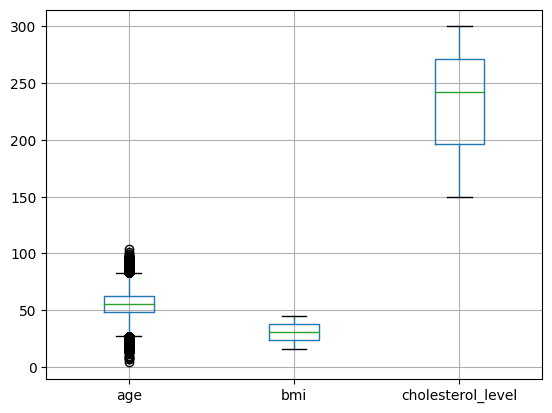

In [6]:
#Let check the outliers 
df_outliers = ['age','bmi','cholesterol_level']
data[df_outliers].boxplot()

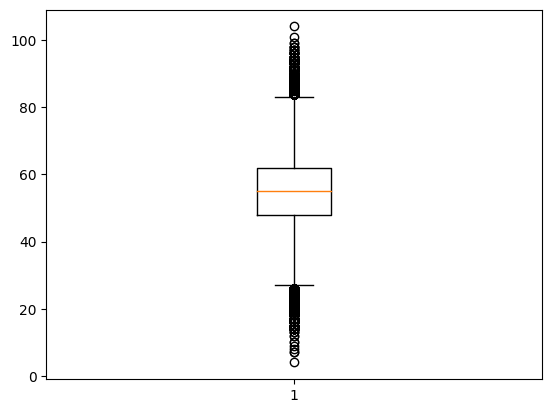

In [13]:
plt.boxplot(data.age); #Age has more outliers data points 

In [ ]:
#Let the outliers of Age remains same and see will it impact on our model or not?

**Feature Selection**

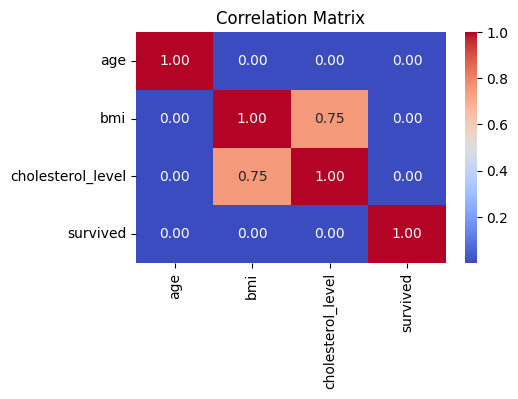

survived             1.000000
age                  0.001233
cholesterol_level    0.000157
bmi                  0.000007
Name: survived, dtype: float64


In [26]:
#Checking for which features are making relation with each others and with our target feature
cor = data[['age','bmi','cholesterol_level','survived']].corr() 
#bmi and cholesterol related with each other

#Visulization 
plt.figure(figsize=(5,3))
sns.heatmap(cor,annot=True,cmap='coolwarm',fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

#Relation with Target['survived']
cor_target = cor['survived'].sort_values(ascending=False)
print(cor_target)

In [24]:
#Let we ============================try the SelectKBest : feature Selection Algo..=======================
#First Try on Numerical data Value
feature_X = data[['age','bmi','cholesterol_level']]
feature_y = data['survived']
selector = SelectKBest(score_func=f_classif,k='all')  #here k=all that shows all feature scores
feature_x_new = selector.fit_transform(feature_X,feature_y)
#Result of feature
feature_score = pd.DataFrame({
    'Feature' : feature_X.columns,
    'Score' : selector.scores_,
    'P-value':selector.pvalues_
}).sort_values(by='Score',ascending=False)
print(feature_score)
print("="*70)
# Try on categorical  data Value
feature_X_cg = data[['gender','country','family_history','smoking_status','cancer_stage','hypertension','asthma','cirrhosis','other_cancer', 'treatment_type']]
feature_y = data[['survived']]
# Encoding for categorical value
df_cg_feature = pd.get_dummies(feature_X_cg,drop_first=True)
selector_cg = SelectKBest(score_func=chi2,k='all')  #here k=all that shows all feature scores
feature_x_n_cg = selector_cg.fit_transform(df_cg_feature,feature_y)
#Result of feature
feature_score_cg = pd.DataFrame({
    'Feature' : df_cg_feature.columns,
    'Score' : selector_cg.scores_,
    'P-value':selector_cg.pvalues_
}).sort_values(by='Score',ascending=False)
print(feature_score_cg)

             Feature     Score   P-value
0                age  1.353906  0.244597
2  cholesterol_level  0.022026  0.882018
1                bmi  0.000041  0.994904
                          Feature     Score   P-value
13                 country_France  3.862250  0.049384
30                 country_Sweden  3.345188  0.067402
3                    other_cancer  3.155151  0.075688
18                  country_Italy  2.678741  0.101696
2                       cirrhosis  2.635428  0.104504
40         treatment_type_Surgery  2.094894  0.147792
37          cancer_stage_Stage IV  1.675719  0.195494
11                country_Estonia  1.597740  0.206224
27               country_Slovakia  1.572519  0.209842
1                          asthma  1.544603  0.213934
9          country_Czech Republic  1.395139  0.237539
23            country_Netherlands  1.089580  0.296564
22                  country_Malta  1.051228  0.305224
19                 country_Latvia  0.985445  0.320858
12                country_

In [22]:
#we can see there are many features with low score but significant p-value,
#so we consider all of them and continue with our model 

**Some Data Analysis**

In [29]:
stats = data.groupby('gender')[['bmi','cholesterol_level']].describe()
print(stats)

             bmi                                                      
           count       mean       std   min   25%   50%   75%   max   
gender                                                                
Female  444866.0  30.489951  8.369305  16.0  23.2  30.5  37.7  45.0  \
Male    445134.0  30.498389  8.367781  16.0  23.3  30.5  37.8  45.0   

       cholesterol_level                                                      
                   count        mean        std    min    25%    50%    75%   
gender                                                                        
Female          444866.0  233.624183  43.445918  150.0  196.0  242.0  271.0  \
Male            445134.0  233.643642  43.418688  150.0  196.0  242.0  271.0   

               
          max  
gender         
Female  300.0  
Male    300.0  


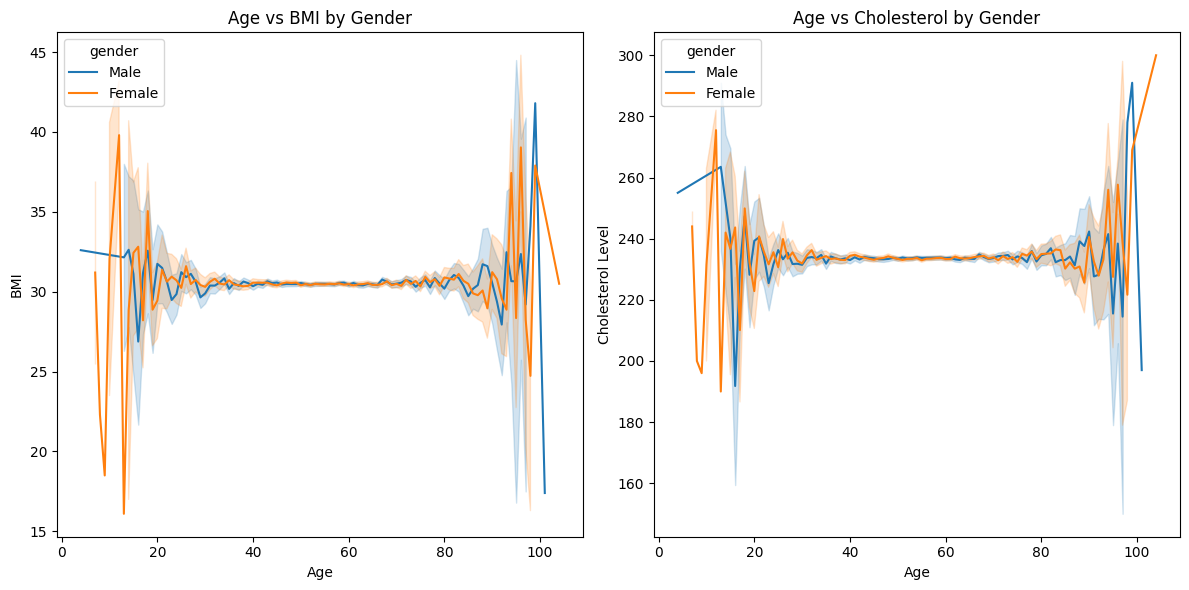

In [38]:
# Line plot for Age vs BMI by Gender
plt.figure(figsize=(12, 6))

# Plot BMI trends by gender
plt.subplot(1, 2, 1)
sns.lineplot(x='age', y='bmi', hue='gender', data=data)
plt.title('Age vs BMI by Gender')
plt.xlabel('Age')
plt.ylabel('BMI')

# Plot Cholesterol trends by gender
plt.subplot(1, 2, 2)
sns.lineplot(x='age', y='cholesterol_level', hue='gender', data=data)
plt.title('Age vs Cholesterol by Gender')
plt.xlabel('Age')
plt.ylabel('Cholesterol Level')
plt.tight_layout()
plt.show()

#We can see there are diffrent trends in males and female for BMI and Cholestrol as per their age
#BMI : small age women has higher bmi ans old age men has higher bmi
#Cholestrol : Mostly Similar 

**Models Development and Evaluation**

In [3]:
df = data.copy() #shallow copy of orignal data
#Lets Count the values present in dataframe
c = ['cancer_stage','family_history','smoking_status','treatment_type']
for i in c:
    count = Counter(df[i])
    print(f'{i}:{count}')

cancer_stage:Counter({'Stage III': 222594, 'Stage IV': 222527, 'Stage I': 222516, 'Stage II': 222363})
family_history:Counter({'No': 445181, 'Yes': 444819})
smoking_status:Counter({'Passive Smoker': 223170, 'Never Smoked': 222751, 'Former Smoker': 222181, 'Current Smoker': 221898})
treatment_type:Counter({'Chemotherapy': 223262, 'Surgery': 223261, 'Combined': 222609, 'Radiation': 220868})


In [49]:
df.columns

Index(['id', 'age', 'gender', 'country', 'diagnosis_date', 'cancer_stage',
       'family_history', 'smoking_status', 'bmi', 'cholesterol_level',
       'hypertension', 'asthma', 'cirrhosis', 'other_cancer', 'treatment_type',
       'end_treatment_date', 'survived'],
      dtype='object')

In [ ]:
#Now we do Encoding
#Label(Ordinal) Encoding with : cancer_stage,smoking_status <- they follow the order 
#One-Hot(Nominal) Encoding with : treatment_type,country, 
#Binary Encoding with : gender,family_history

In [4]:
#Drop unnecessory columns 
df.drop(['id','diagnosis_date','end_treatment_date'],axis=1,inplace=True)

In [5]:
#Binary Encoding 
df['gender'] = df['gender'].map({'Female':0,'Male':1}) 
df['family_history'] = df['family_history'].map({'No':0,'Yes':1})

In [6]:
#Label Encoding 
le = LabelEncoder()
df['cancer_stage'] = le.fit_transform(df['cancer_stage'])
df['smoking_status'] = le.fit_transform(df['smoking_status'])

In [7]:
#one-hot encoding 
df = pd.get_dummies(df,columns=['treatment_type','country'])
df = df.astype(int)

In [130]:
df #As we can see all the Chategorical value becomes numerical 

,age,gender,cancer_stage,family_history,smoking_status,bmi,cholesterol_level,hypertension,asthma,cirrhosis,...,country_Luxembourg,country_Malta,country_Netherlands,country_Poland,country_Portugal,country_Romania,country_Slovakia,country_Slovenia,country_Spain,country_Sweden
0,64,1,0,1,3,29,199,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,50,0,2,1,3,41,280,1,1,0,...,0,0,1,0,0,0,0,0,0,0
2,65,0,2,1,1,44,268,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,51,0,0,0,3,43,241,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,37,1,0,0,3,19,178,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
889995,40,1,3,0,3,44,243,1,1,1,...,0,1,0,0,0,0,0,0,0,0
889996,62,0,1,1,1,21,240,0,0,0,...,0,0,0,0,0,0,0,0,0,0
889997,48,0,2,1,2,38,242,1,0,0,...,0,0,0,0,0,0,0,0,0,0
889998,67,0,3,1,1,18,194,1,1,0,...,0,0,0,0,0,0,1,0,0,0


In [8]:
#Train-Test Split data
X = df.drop(['survived'],axis=1)
y = df['survived']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42,stratify=y) #Train :70%, Test : 30%
print(X_train.shape,X_test.shape)

(623000, 42) (267000, 42)


In [9]:
#Standardization (Z-score Scaling) 
numerical_feature = ['age','bmi','cholesterol_level']
scaler = StandardScaler()
#Apply on Traning Data
X_train[numerical_feature] = scaler.fit_transform(X_train[numerical_feature])

In [16]:
#===============================Model Number 1 : Logistic Regression============================= 

LR_model = LogisticRegression(max_iter=500,class_weight='balanced').fit(X_train,y_train)
#Before Prediction let get back the scale data for test
X_test[numerical_feature] = scaler.transform(X_test[numerical_feature])
#Prediction 
pred_LRmodel = LR_model.predict(X_test)


Logistic Regression
Accuracy Score on Test data :74.27%
              precision    recall  f1-score   support

           0       0.78      0.93      0.85    208199
           1       0.22      0.07      0.10     58801

    accuracy                           0.74    267000
   macro avg       0.50      0.50      0.48    267000
weighted avg       0.66      0.74      0.69    267000

[[194323  13876]
 [ 54816   3985]]
Confusion Matrix for Logistic Regression


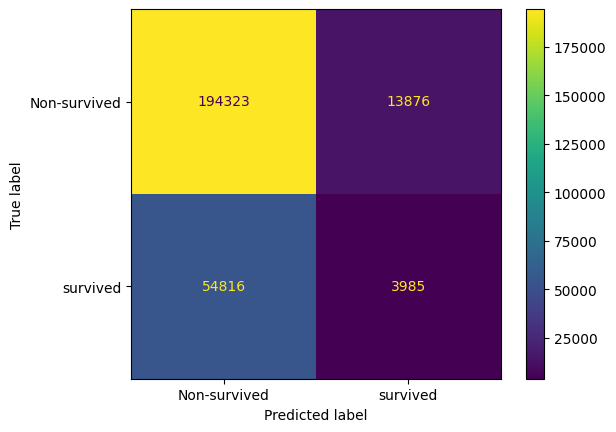

In [17]:
#========================================Evaluation for Logistic Regression=================
print("Logistic Regression")
accu_test = accuracy_score(y_test,pred_LRmodel)
print(f'Accuracy Score on Test data :{accu_test*100:.2f}%')
#Classification Report 
clreport_LR = classification_report(y_test,pred_LRmodel,zero_division=0)
print(clreport_LR)
cnmat_LR = confusion_matrix(y_test,pred_LRmodel)
print(cnmat_LR)
cnmat_LR_disp = ConfusionMatrixDisplay(confusion_matrix=cnmat_LR,display_labels=['Non-survived','survived'])
print("Confusion Matrix for Logistic Regression")
cnmat_LR_disp.plot();

In [13]:
#Logistic Regression as with 74% Accuracy 
#Result : Our model is highly biased, imbalanced with larger data and features 

In [ ]:
#Let's Improve it with some Technics 

              precision    recall  f1-score   support

           0       0.78      0.79      0.79    208199
           1       0.22      0.21      0.21     58801

    accuracy                           0.66    267000
   macro avg       0.50      0.50      0.50    267000
weighted avg       0.66      0.66      0.66    267000

0.6630823970037453


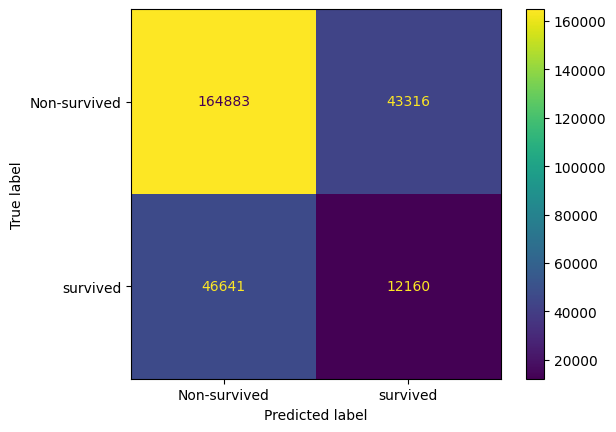

In [20]:
#SMOTE : smote is technic to over sampling for imbalance dataset and it will work for minority class, i.e. : survived
smote = SMOTE(random_state=42)
x_train_smote,y_train_smote = smote.fit_resample(X_train,y_train)
x_train_scaled = scaler.fit_transform(x_train_smote)
x_test_scaled = scaler.transform(X_test)
LR_model_2 = LogisticRegression(max_iter=1000).fit(x_train_scaled,y_train_smote)
pred_LRmodel_2 = LR_model_2.predict(x_test_scaled)
clreport_LR_2 = classification_report(y_test,pred_LRmodel_2)
print(clreport_LR_2)
cnmat_LR_2 = confusion_matrix(y_test,pred_LRmodel_2)
cnmat_LR_2_disp = ConfusionMatrixDisplay(confusion_matrix=cnmat_LR_2,display_labels=['Non-survived','survived'])
cnmat_LR_2_disp.plot();
accu_test_smote = accuracy_score(y_test,pred_LRmodel_2)
print(accu_test_smote)
#Result of Smote : 66.30% accuracy 
#We get the more value of True positive and False Positive but with less accuracy 

In [25]:
# #Hyperparameter Tuning : For improve the model performance <-Taking too much time to execute 
# parameter = {
#     'C':[0.01,0.1,1,10,100],
#     'penalty' : ['l2','l1'],
#     'solver':['liblinear','saga']
# }
# grid_search = GridSearchCV(LogisticRegression(random_state=42),param_grid=parameter,cv=5,scoring='accuracy')
# grid_search.fit(X_train,y_train)
# print("Best Parameters:",grid_search.best_params_)
# print("Best Score:",grid_search.best_score_)

Accuracy Score for Random Forest :77.98
              precision    recall  f1-score   support

           0       0.78      1.00      0.88    208199
           1       0.25      0.00      0.00     58801

    accuracy                           0.78    267000
   macro avg       0.51      0.50      0.44    267000
weighted avg       0.66      0.78      0.68    267000



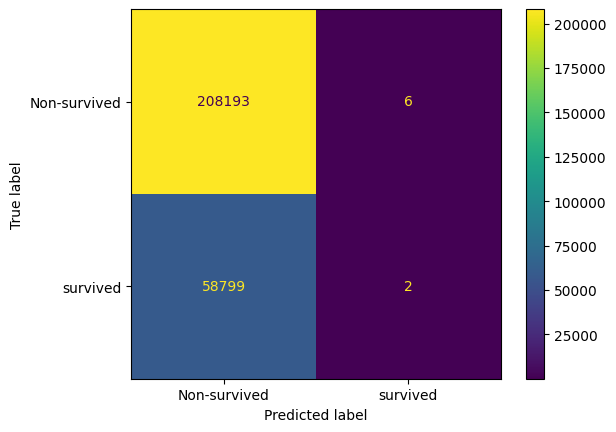

In [11]:
#=====================================Model 2 : Random Forest=======================================
RF_model = RandomForestClassifier(n_estimators=200,max_depth=20,random_state=42,class_weight='balanced').fit(X_train,y_train)
#Prediction 
pred_RFmodel = RF_model.predict(X_test)
accu_test_RF = accuracy_score(y_test,pred_RFmodel)
print(f'Accuracy Score for Random Forest :{accu_test_RF*100:.2f}')
clreport_RF = classification_report(y_test,pred_RFmodel,zero_division=0)
print(clreport_RF)
cnmat_RF = confusion_matrix(y_test,pred_RFmodel)
cnmat_RF_disp = ConfusionMatrixDisplay(confusion_matrix=cnmat_RF,display_labels=['Non-survived','survived'])
cnmat_RF_disp.plot();
# Result of Random Forest : with 77.98% accuracy still the precision and recall for survived is very low 
# out of all survived patient only 25% predicted as survived and 0% recall means the model is not identify the actual survived 
# correctly 

In [14]:
y_test.value_counts()

survived
0    208199
1     58801
Name: count, dtype: int64

In [ ]:
#See even after the Random forest which is much powerful with it's decision tree and parameters still the prediction is low 
#Let try another algoritham 

Accuracy of xgb:77.97
Classification Report               precision    recall  f1-score   support

           0       0.78      1.00      0.88    208199
           1       0.28      0.00      0.00     58801

    accuracy                           0.78    267000
   macro avg       0.53      0.50      0.44    267000
weighted avg       0.67      0.78      0.68    267000



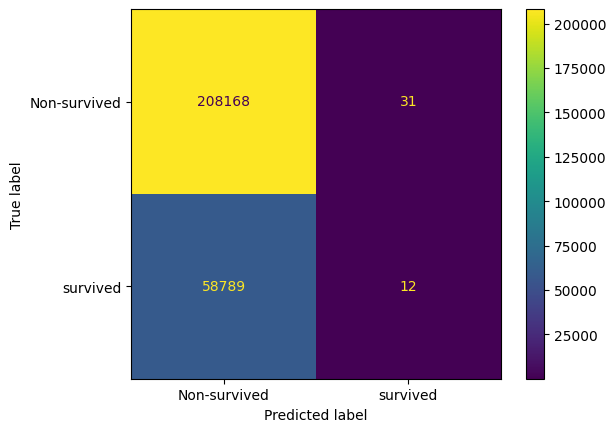

In [19]:
#*****************************************Model 3 : XGBoost******************************************
#-----------------------------------------------------------------------------------------------------
#this algo is upper vesrion of gradient boosting and more robust, suited for large and complex data 
#Let try and check will it work or not ?
#===================================Try-1=============================================================
xgb_model =  xgb.XGBClassifier(
    objective='binary:logistic',                #for binary classification (survived and not-survived)
    n_estimators = 200,
    max_depth=8,
    learning_rate=0.05,
    subsample = 0.8,
    colsample_bytree = 0.8,
    random_state = 42
)
xgb_model.fit(X_train,y_train)
pred_xgbmodel = xgb_model.predict(X_test)
#Model Try-1 Evaluation 
accu_xgbmodel = accuracy_score(y_test,pred_xgbmodel)
clreport_xgb = classification_report(y_test,pred_xgbmodel)
cnmat_xgb = confusion_matrix(y_test,pred_xgbmodel)
print(f'Accuracy of xgb:{accu_xgbmodel*100:.2f}')
print('Classification Report',clreport_xgb)
cnmat_xgb_disp = ConfusionMatrixDisplay(confusion_matrix=cnmat_xgb,display_labels=['Non-survived','survived'])
cnmat_xgb_disp.plot();

Accuracy of xgb:75.92
Classification Report               precision    recall  f1-score   support

           0       0.78      0.96      0.86    208199
           1       0.21      0.04      0.06     58801

    accuracy                           0.76    267000
   macro avg       0.50      0.50      0.46    267000
weighted avg       0.66      0.76      0.69    267000



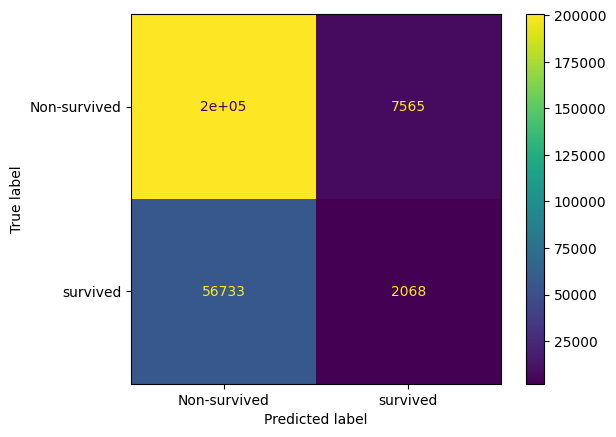

In [20]:
#===============================Try-2 : xgb model with handling imbalanced data============================ 
#Let calculate the scale pos weight : the ratio of negative and positive classes
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)
xgb_model_t2 = xgb.XGBClassifier(
    objective='binary:logistic',                #for binary classification (survived and not-survived)
    n_estimators = 200,
    max_depth=8,
    learning_rate=0.05,
    subsample = 0.8,
    colsample_bytree = 0.8,
    scale_pos_weight = scale_pos_weight,
    random_state = 42
)
xgb_model_t2.fit(X_train,y_train)
pred_xgbmodel_t2 = xgb_model_t2.predict(X_test)
#Model Try-2 Evaluation 
accu_xgbmodel_t2 = accuracy_score(y_test,pred_xgbmodel_t2)
clreport_xgb_t2 = classification_report(y_test,pred_xgbmodel_t2)
cnmat_xgb_t2 = confusion_matrix(y_test,pred_xgbmodel_t2)
print(f'Accuracy of xgb:{accu_xgbmodel_t2*100:.2f}')
print('Classification Report',clreport_xgb_t2)
cnmat_xgb_disp_t2 = ConfusionMatrixDisplay(confusion_matrix=cnmat_xgb_t2,display_labels=['Non-survived','survived'])
cnmat_xgb_disp_t2.plot();

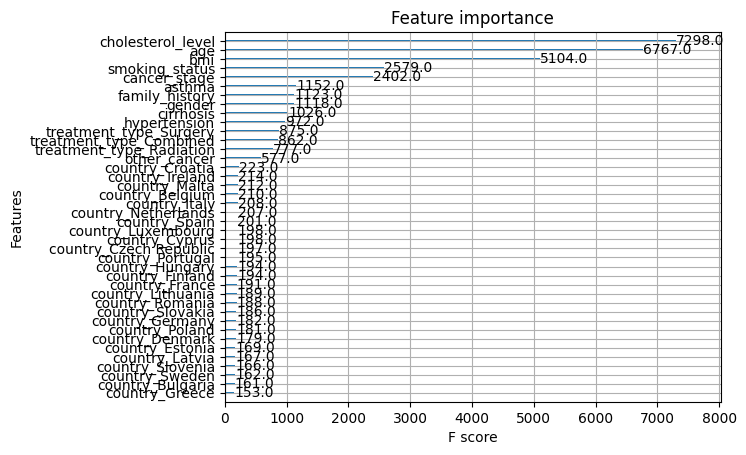

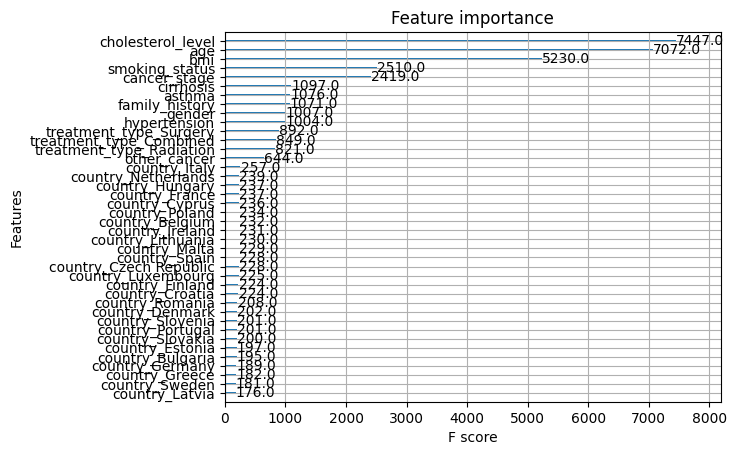

In [25]:
xgb.plot_importance(xgb_model)
plt.show()
xgb.plot_importance(xgb_model_t2)
plt.show()

In [12]:
#Even After making and evaluating many models the prediction remain same 
#Let Drop Country feature(As in xgboost it's less supportive) and check whether is works or not 
X_train.columns

Index(['age', 'gender', 'cancer_stage', 'family_history', 'smoking_status',
       'bmi', 'cholesterol_level', 'hypertension', 'asthma', 'cirrhosis',
       'other_cancer', 'treatment_type_Chemotherapy',
       'treatment_type_Combined', 'treatment_type_Radiation',
       'treatment_type_Surgery', 'country_Austria', 'country_Belgium',
       'country_Bulgaria', 'country_Croatia', 'country_Cyprus',
       'country_Czech Republic', 'country_Denmark', 'country_Estonia',
       'country_Finland', 'country_France', 'country_Germany',
       'country_Greece', 'country_Hungary', 'country_Ireland', 'country_Italy',
       'country_Latvia', 'country_Lithuania', 'country_Luxembourg',
       'country_Malta', 'country_Netherlands', 'country_Poland',
       'country_Portugal', 'country_Romania', 'country_Slovakia',
       'country_Slovenia', 'country_Spain', 'country_Sweden'],
      dtype='object')

In [13]:
#Drop the country encoded data 
X_train.drop(X_train.iloc[:,15:],axis=1,inplace=True)
X_test.drop(X_test.iloc[:,15:],axis=1,inplace=True)

In [14]:
X_test.head(10)

,age,gender,cancer_stage,family_history,smoking_status,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,treatment_type_Chemotherapy,treatment_type_Combined,treatment_type_Radiation,treatment_type_Surgery
276496,52,0,2,0,3,44,256,1,0,1,0,1,0,0,0
508774,63,0,1,0,3,20,156,1,1,0,0,0,0,0,1
806348,66,1,0,1,0,23,226,1,0,0,0,1,0,0,0
544866,61,1,1,0,0,35,244,0,0,0,0,0,0,0,1
365904,67,1,3,1,0,37,293,0,0,1,0,0,0,0,1
133722,62,1,1,1,0,37,249,1,1,0,0,1,0,0,0
424071,48,0,3,0,3,40,273,1,0,1,0,0,0,0,1
298962,55,0,2,1,2,28,214,1,0,0,1,0,1,0,0
672417,42,1,2,1,1,27,156,1,0,1,0,1,0,0,0
356236,71,0,2,0,2,23,207,0,0,0,0,1,0,0,0


In [15]:
#Standardization (Z-score Scaling) 
scaler = StandardScaler()
#Apply on Traning Data
X_train_scaled = scaler.fit_transform(X_train)

In [16]:
X_test_scaled = scaler.transform(X_test)

Accuracy of xgb:77.98%
Classification Report               precision    recall  f1-score   support

           0       0.78      1.00      0.88    208199
           1       0.00      0.00      0.00     58801

    accuracy                           0.78    267000
   macro avg       0.39      0.50      0.44    267000
weighted avg       0.61      0.78      0.68    267000



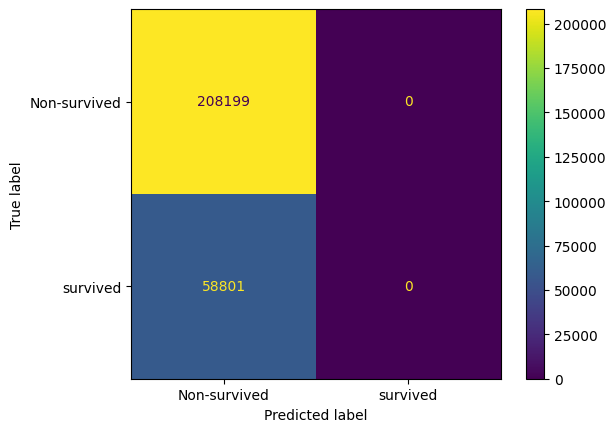

In [80]:
#====================================Try-3 Model : XGBoost================================================= 
xgb_model_t3 = xgb.XGBClassifier(
    objective='binary:logistic',                #for binary classification (survived and not-survived)
    n_estimators = 200,
    max_depth=8,
    learning_rate=0.05,
    subsample = 0.8,
    colsample_bytree = 0.8,
    random_state = 42
)
xgb_model_t3.fit(X_train_scaled,y_train)
pred_xgbmodel_t3 = xgb_model_t3.predict(X_test_scaled)
#Model Try-3 Evaluation 
accu_xgbmodel_t3 = accuracy_score(y_test,pred_xgbmodel_t3)
clreport_xgb_t3 = classification_report(y_test,pred_xgbmodel_t3,zero_division=0)
cnmat_xgb_t3 = confusion_matrix(y_test,pred_xgbmodel_t3)
print(f'Accuracy of xgb:{accu_xgbmodel_t3*100:.2f}%')
print('Classification Report',clreport_xgb_t3)
cnmat_xgb_disp_t3 = ConfusionMatrixDisplay(confusion_matrix=cnmat_xgb_t3,display_labels=['Non-survived','survived'])
cnmat_xgb_disp_t3.plot();

Accuracy of xgb:76.94%
Classification Report               precision    recall  f1-score   support

           0       0.78      0.98      0.87    208199
           1       0.21      0.02      0.03     58801

    accuracy                           0.77    267000
   macro avg       0.50      0.50      0.45    267000
weighted avg       0.65      0.77      0.68    267000



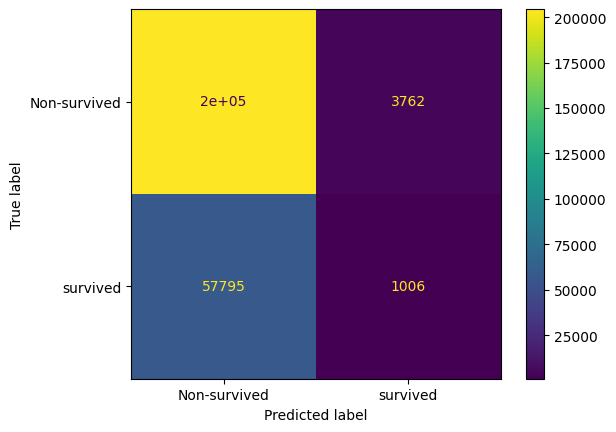

In [17]:
#SMOTE : smote is technic to over sampling for imbalance dataset and it will work for minority class, i.e. : survived
#=====================================Model : xgboost with SMOTE=====================================================
smote = SMOTE(random_state=42,sampling_strategy='auto',k_neighbors=5)
x_train_smote_xgb,y_train_smote_xgb = smote.fit_resample(X_train,y_train)
x_train_scaled_xgb = scaler.fit_transform(x_train_smote_xgb)
x_test_scaled_xgb = scaler.transform(X_test)

scale_pos_weight = sum(y_train_smote_xgb == 0) / sum(y_train_smote_xgb == 1)
# the XGBoost classifier
xgb_model_2 = xgb.XGBClassifier(
    objective='binary:logistic', 
    n_estimators=200, 
    max_depth=8, 
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

# Fit the model
xgb_model_2.fit(x_train_scaled_xgb, y_train_smote_xgb.values)
# Predict on test data
y_pred_xgb = xgb_model_2.predict(x_test_scaled_xgb)

#Model 3.1 Evaluation 
accu_xgbmodel_2 = accuracy_score(y_test,y_pred_xgb)
clreport_xgb_2 = classification_report(y_test,y_pred_xgb,zero_division=0)
cnmat_xgb_2 = confusion_matrix(y_test,y_pred_xgb)
print(f'Accuracy of xgb:{accu_xgbmodel_2*100:.2f}%')
print('Classification Report',clreport_xgb_2)
cnmat_xgb_disp_2 = ConfusionMatrixDisplay(confusion_matrix=cnmat_xgb_2,display_labels=['Non-survived','survived'])
cnmat_xgb_disp_2.plot();

Result : All Model Gives approx 75% accuracy on this dataset 

In [96]:
#Let try with only numrical features like : age,bmi and cholesterol_level
df2 = data.copy()
df2 = df[['age','bmi','cholesterol_level','survived']]

In [98]:
df2.head(5)

,age,bmi,cholesterol_level,survived
0,64,29,199,0
1,50,41,280,1
2,65,44,268,0
3,51,43,241,0
4,37,19,178,0


Accuracy of xgb:51.98%
Classification Report               precision    recall  f1-score   support

           0       0.78      0.53      0.63    207984
           1       0.22      0.47      0.30     59016

    accuracy                           0.52    267000
   macro avg       0.50      0.50      0.47    267000
weighted avg       0.66      0.52      0.56    267000



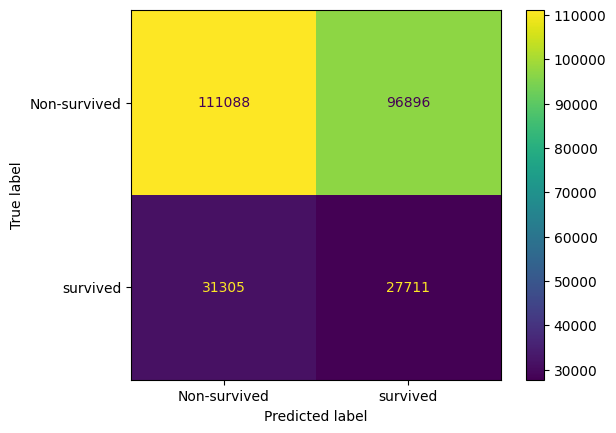

In [100]:
#===========================================Model 4 : XGB==================================================
#THis model only has numrical features 
df2_x = df2.drop(columns=['survived'])
df2_y = df2['survived']
df2_x_train,df2_x_test,df2_y_train,df2_y_test = train_test_split(df2_x,df2_y,test_size=0.3,random_state=42)
#df2_x_train_scaled = scaler.fit_transform(df2_x_train)
#df2_x_test_scaled = scaler.transform(df2_x_test)

smote = SMOTE(random_state=42,sampling_strategy='auto',k_neighbors=5)
df2_x_train_smote_xgb,df2_y_train_smote_xgb = smote.fit_resample(df2_x_train,df2_y_train)
df2_x_train_scaled_xgb = scaler.fit_transform(df2_x_train_smote_xgb)
df2_x_test_scaled_xgb = scaler.transform(df2_x_test)

scale_pos_weight = sum(y_train_smote_xgb == 0) / sum(y_train_smote_xgb == 1)

xgb_model_4 = xgb.XGBClassifier(
    objective='binary:logistic', 
    n_estimators=200, 
    max_depth=8, 
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

# Fit the model
xgb_model_4.fit(df2_x_train_scaled_xgb,df2_y_train_smote_xgb)
# Predict on test data
y_pred_xgb_4 = xgb_model_4.predict(df2_x_test_scaled_xgb)

#Model 3.1 Evaluation 
accu_xgbmodel_4 = accuracy_score(df2_y_test,y_pred_xgb_4)
clreport_xgb_4 = classification_report(df2_y_test,y_pred_xgb_4,zero_division=0)
cnmat_xgb_4 = confusion_matrix(df2_y_test,y_pred_xgb_4)
print(f'Accuracy of xgb:{accu_xgbmodel_4*100:.2f}%')
print('Classification Report',clreport_xgb_4)
cnmat_xgb_disp_4 = ConfusionMatrixDisplay(confusion_matrix=cnmat_xgb_4,display_labels=['Non-survived','survived'])
cnmat_xgb_disp_4.plot();

In [20]:
#Prediction on Unseen data 
inpu = np.array([[64,1,0,1,3,29,199,0,0,1,0,1,0,0,0]])
scale_test = scaler.transform(inpu)
unseen_pred = xgb_model_2.predict(scale_test)
if unseen_pred[0] == 1:
    print("Patient likely to be survived with probably")
else:
    print("Patient likely to be No-survived")

Patient likely to be No-survived


C:\Users\Tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


**Conclusion**:
In this project, we developed a system to predict patient survival using features like age, cancer stage, and treatment type. After preprocessing the data with encoding techniques and feature scaling, we tested various models, including logistic regression,Random Forest and XGBoost. Despite efforts like SMOTE for class imbalance,Hyper Parameter Tuning for improvement model performance, the model accuracy stabilized around 75-77%. XGBoost and Logistic provided the best results, highlighting the importance of careful feature engineering and handling imbalanced data.